In [37]:
import pandas as pd
from matplotlib import pyplot as py
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [38]:
df = pd.read_excel("premiums_rest.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [39]:
df.shape

(29904, 13)

In [40]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [41]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [42]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle NA Value

In [43]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [44]:
df.shape

(29886, 13)

In [45]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [46]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [47]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-1, -3])

In [48]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [49]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

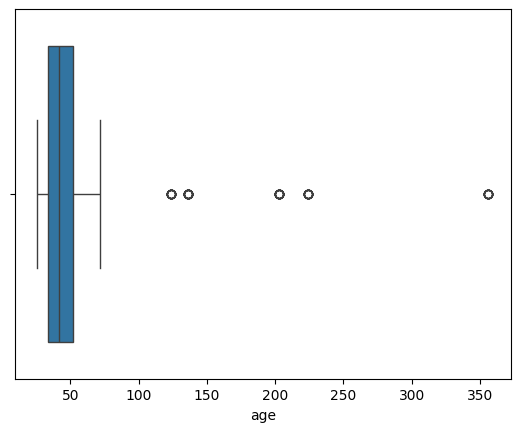

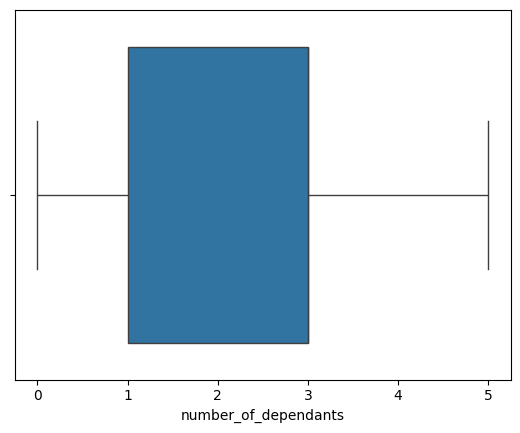

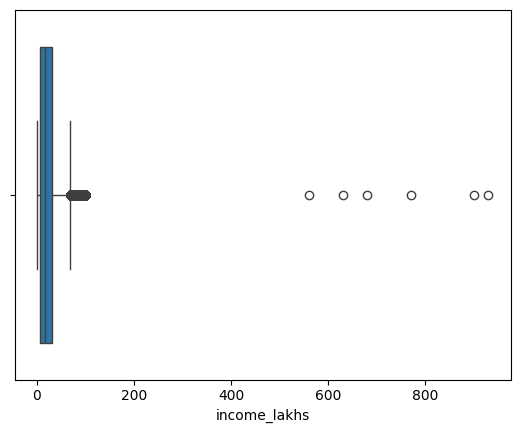

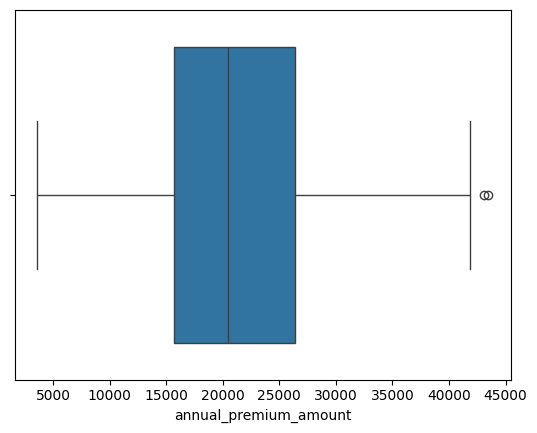

In [50]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    py.show()

In [51]:
df[df.age>100].shape

(58, 13)

In [52]:
df[df.age>100]["age"].unique()

array([224, 124, 136, 203, 356])

In [53]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


In [54]:
df.income_lakhs.quantile([0.25,0.75])

0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [55]:
def get_iqr_bonds(col1):
    Q1,Q3 = df.income_lakhs.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5* IQR
    return lower_bound,upper_bound

In [56]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [57]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


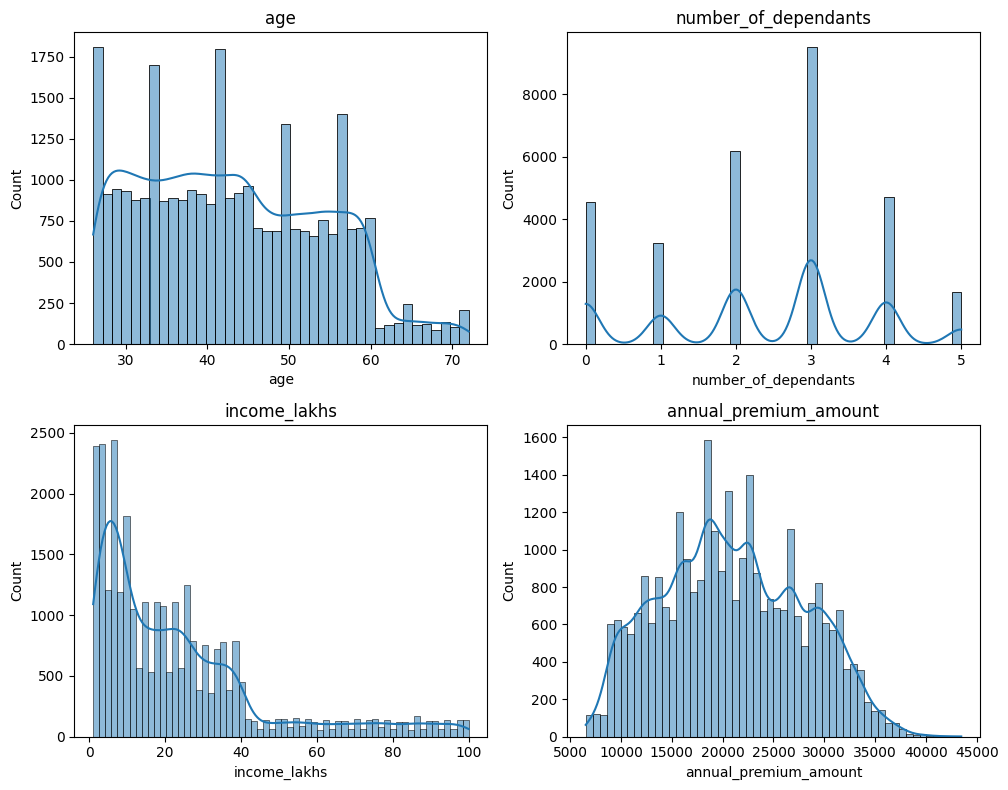

In [58]:
fig,axs = py.subplots(nrows=2,ncols=2,figsize=(10,8))

for i,col in enumerate(numeric_columns):
    ax = axs[i//2,i%2]
    sns.histplot(df2[col],kde=True,ax=ax)
    ax.set_title(col)

py.tight_layout()
py.show()

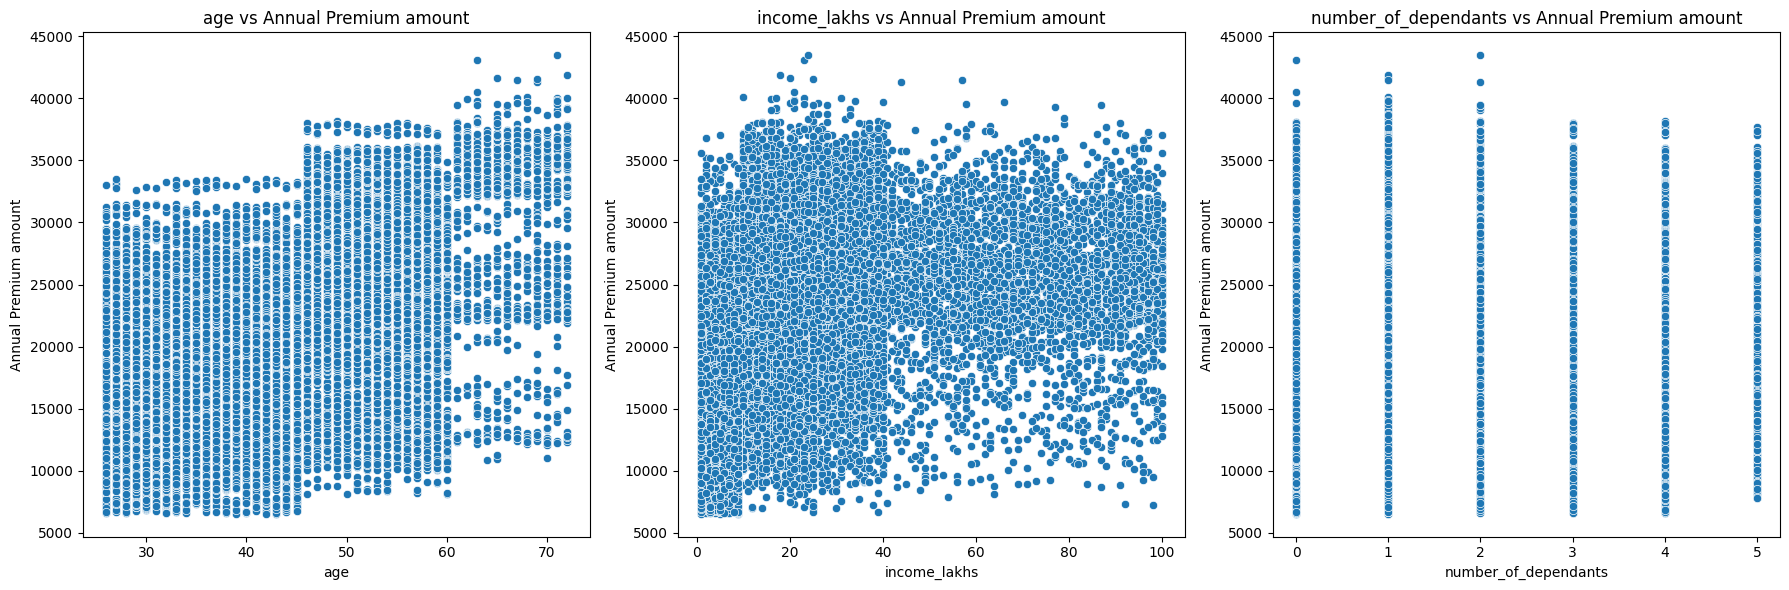

In [59]:
numeric_features = ["age","income_lakhs","number_of_dependants"]

fig,axes = py.subplots(1,len(numeric_features),figsize=(18,6))

for ax,column in zip(axes,numeric_features):
    sns.scatterplot(x=df2[column],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f"{column} vs Annual Premium amount")
    ax.set_xlabel(column)
    ax.set_ylabel("Annual Premium amount")

py.tight_layout()
py.show()

In [60]:
categorical_columns = ["gender","region","marital_status","bmi_category","smoking_status","employment_status","income_level"
                      ,"medical_history","insurance_plan"]
for col in categorical_columns:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [61]:
df2["smoking_status"].replace({
    'Smoking=0':"No Smoking",
    "Not Smoking":'No Smoking',
    "Does Not Smoke":"No Smoking"
},inplace=True)

df2["smoking_status"].unique()

C:\Users\91999\AppData\Local\Temp\ipykernel_29544\2825346143.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [62]:
categorical_columns = ["gender","region","marital_status","bmi_category","smoking_status","employment_status","income_level"
                      ,"medical_history","insurance_plan"]
for col in categorical_columns:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [63]:
pct_count = df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

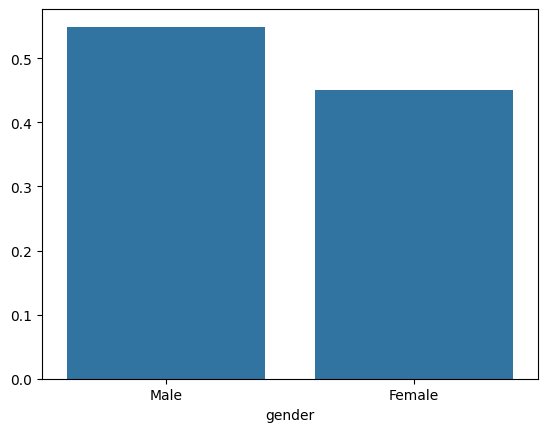

In [64]:
sns.barplot(x=pct_count.index,y=pct_count.values)
py.show()

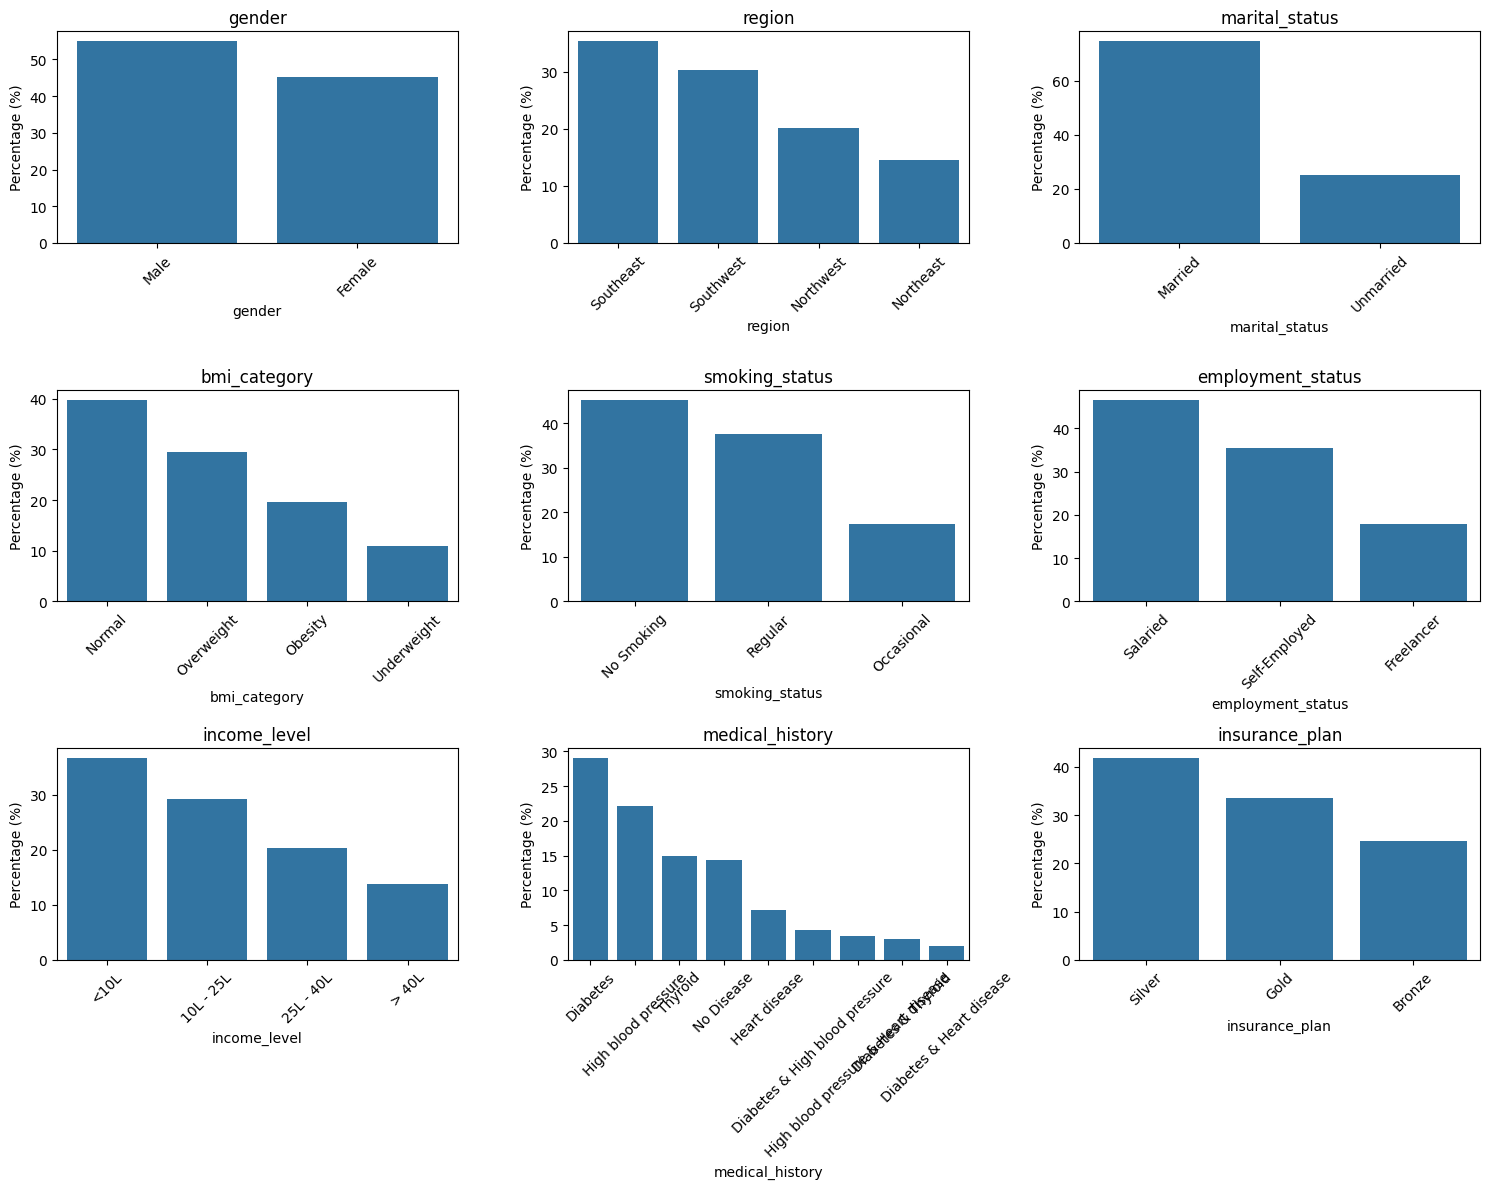

In [65]:
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # ensures enough rows

fig, axes = py.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten in case of extra axes

for i, col in enumerate(categorical_columns):
    ax = axes[i]
    pct_count = df2[col].value_counts(normalize=True) * 100
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(col)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Remove any unused subplots
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

py.tight_layout()
py.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


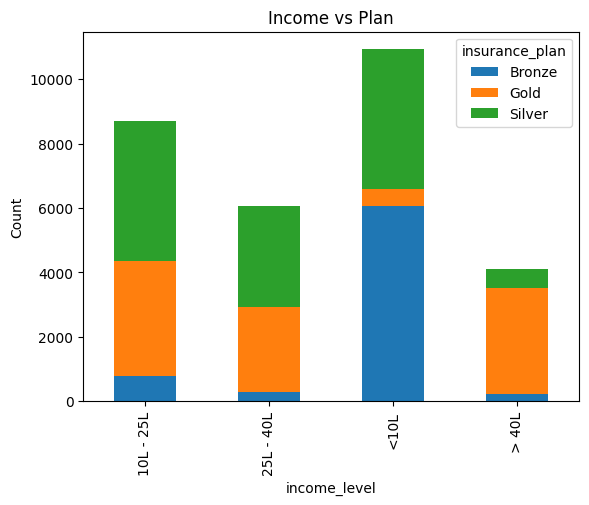

In [66]:
crosstab = pd.crosstab(df2["income_level"],df2["insurance_plan"])
print(crosstab)

crosstab.plot(kind="bar",stacked=True)
py.title("Income vs Plan")
py.ylabel('Count')
py.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

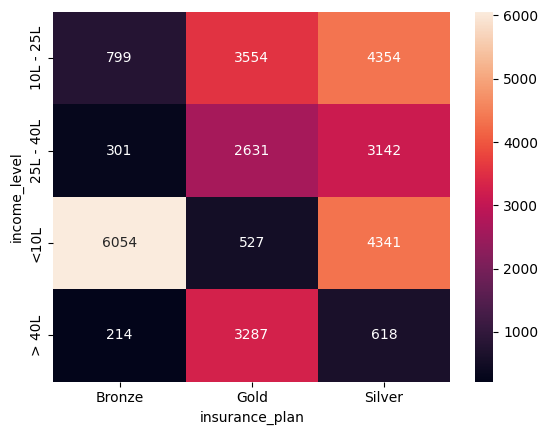

In [67]:
sns.heatmap(crosstab,annot=True,fmt="d")

In [68]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [69]:
df2["medical_history"].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [70]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

df2[["disease1","disease2"]] = df2["medical_history"].str.split(" & ",expand=True).apply(lambda x:x.str.lower())
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29899,60,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,25L - 40L,26,High blood pressure,Gold,26370,high blood pressure,None
29900,40,Female,Southeast,Unmarried,0,Overweight,Regular,Salaried,10L - 25L,16,Diabetes & Thyroid,Gold,29496,diabetes,thyroid
29901,37,Female,Northwest,Unmarried,0,Obesity,No Smoking,Salaried,<10L,4,No Disease,Bronze,10957,no disease,None
29902,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076,thyroid,None


In [71]:
df2["disease1"].fillna("none",inplace=True)
df2["disease2"].fillna("none",inplace=True)
df2["total_risk_score"] = 0

for disease in ["disease1","disease2"]:
    df2["total_risk_score"] += df2[disease].map(risk_scores)

max_score = df2["total_risk_score"].max()
min_score = df2["total_risk_score"].min()

df2["normalized_risk_score"] = (df2["total_risk_score"]-min_score)/(max_score-min_score)
df2.head(5)

C:\Users\91999\AppData\Local\Temp\ipykernel_29544\2819023519.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["disease1"].fillna("none",inplace=True)
C:\Users\91999\AppData\Local\Temp\ipykernel_29544\2819023519.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571


In [72]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
589,39,Male,Northwest,Unmarried,0,Underweight,Regular,Salaried,10L - 25L,19,Thyroid,Silver,19000,thyroid,none,5,0.357143
29015,70,Female,Southeast,Married,1,Normal,No Smoking,Self-Employed,10L - 25L,21,Heart disease,Bronze,16546,heart disease,none,8,0.571429
20140,57,Male,Southeast,Married,3,Normal,Regular,Self-Employed,25L - 40L,34,Diabetes,Gold,29412,diabetes,none,6,0.428571
4585,45,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,> 40L,81,High blood pressure,Silver,17215,high blood pressure,none,6,0.428571
24340,30,Female,Northeast,Married,2,Overweight,Occasional,Salaried,> 40L,44,Thyroid,Gold,24680,thyroid,none,5,0.357143
19860,45,Male,Southwest,Married,3,Normal,No Smoking,Salaried,10L - 25L,21,Heart disease,Silver,19497,heart disease,none,8,0.571429
8558,57,Female,Southwest,Unmarried,0,Obesity,Occasional,Self-Employed,<10L,7,No Disease,Silver,21147,no disease,none,0,0.000000
29586,46,Male,Southwest,Married,3,Normal,No Smoking,Salaried,10L - 25L,23,Thyroid,Gold,26402,thyroid,none,5,0.357143
21304,58,Female,Southwest,Married,4,Obesity,Occasional,Salaried,<10L,1,Diabetes,Bronze,15835,diabetes,none,6,0.428571
3029,28,Female,Southwest,Married,3,Obesity,No Smoking,Salaried,25L - 40L,30,High blood pressure,Silver,19915,high blood pressure,none,6,0.428571


In [73]:
df2["insurance_plan"] = df2["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [74]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [75]:
df2["income_level"] = df2["income_level"].map({'<10L':1,'10L - 25L':2,'25L - 40L':3,'> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,diabetes,none,6,0.428571


In [76]:
nominal_cols = ["gender","region","marital_status","bmi_category","smoking_status","employment_status"]

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [77]:
df4 = df3.drop(["disease1","disease2","medical_history","total_risk_score"],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


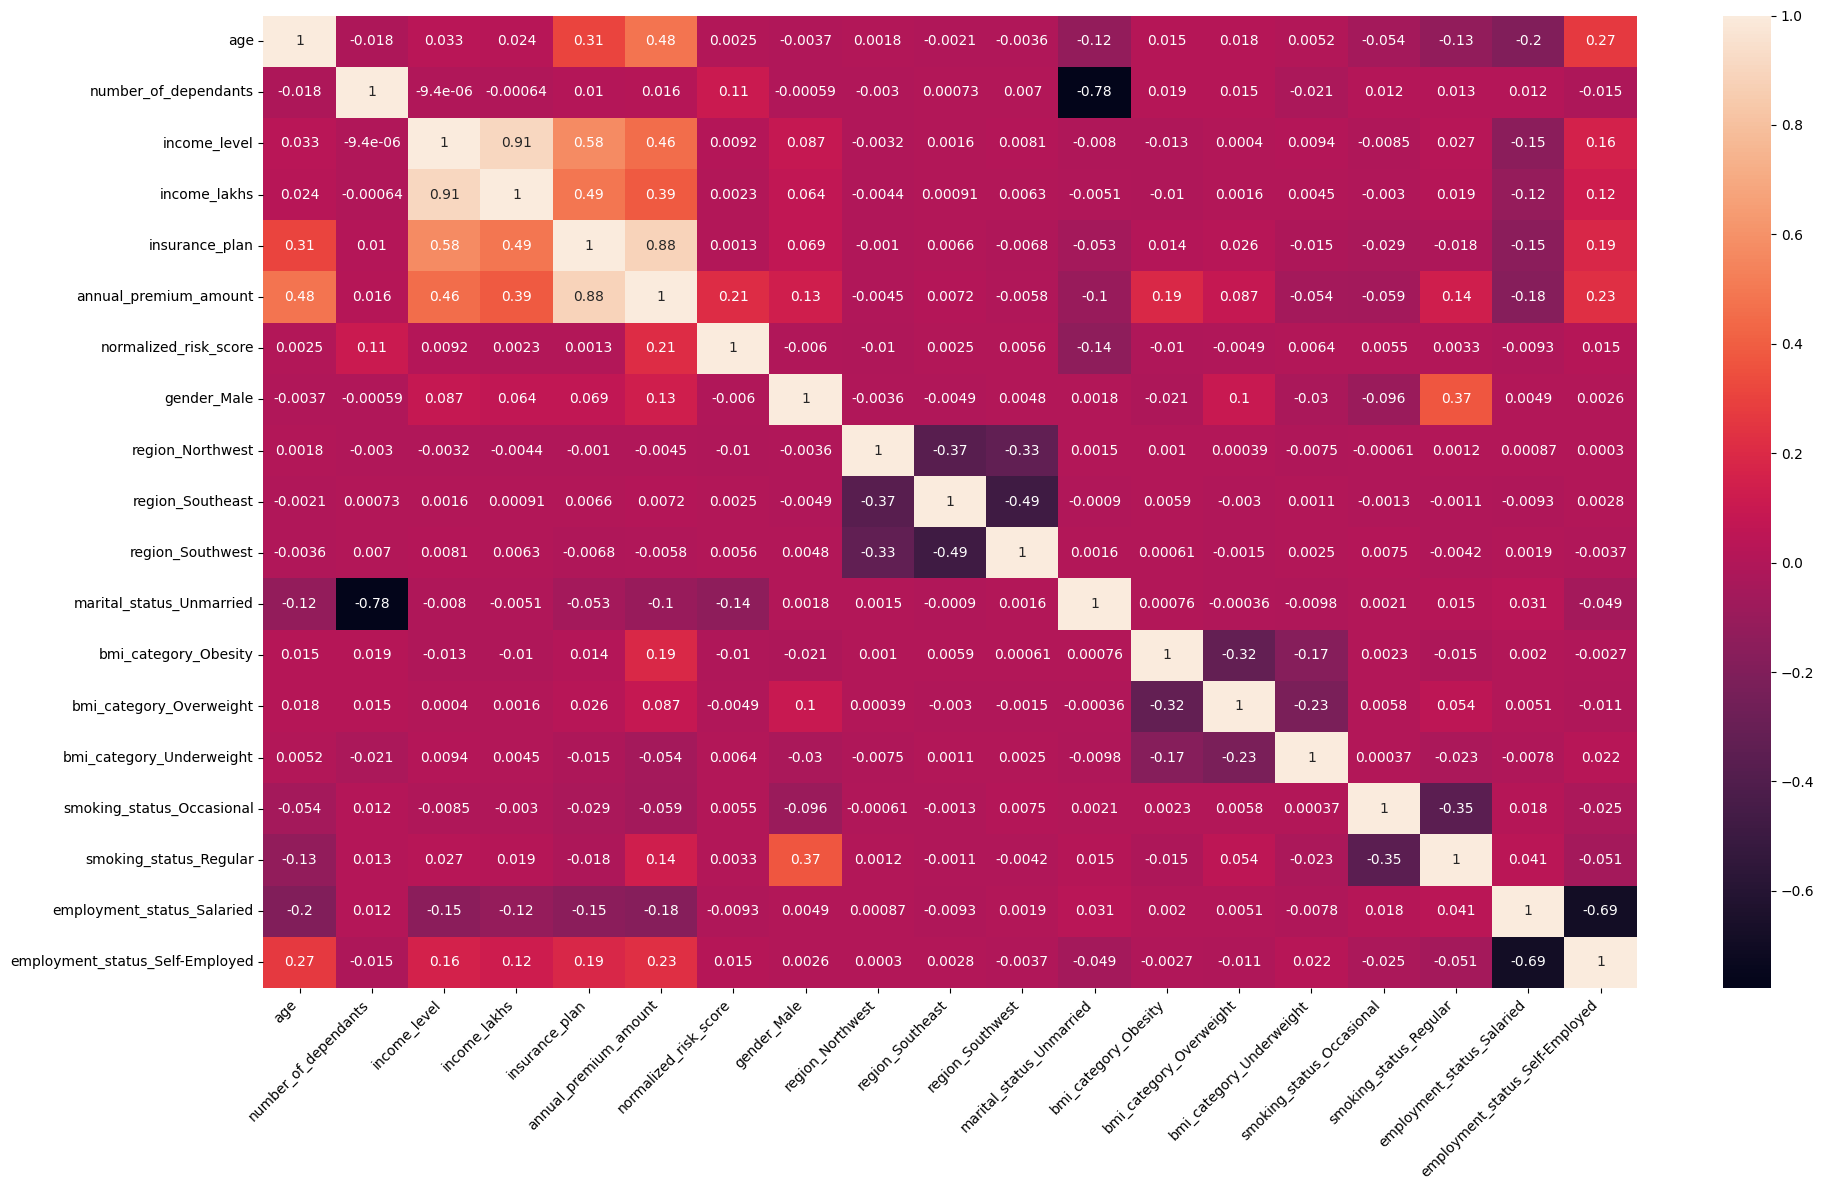

In [78]:
cm = df4.corr()

py.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
py.xticks(rotation=45,ha="right")
py.yticks(rotation=0)
py.tight_layout()
py.show()

In [79]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [80]:
X = df4.drop("annual_premium_amount",axis=1)
Y = df4["annual_premium_amount"]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ["age","number_of_dependants","income_level","income_lakhs","insurance_plan"]
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [82]:
calculate_vif(X)

,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [83]:
calculate_vif(X.drop("income_level",axis=1))

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [84]:
X_reduced = X.drop("income_level",axis=1)
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model Training

In [85]:
X_train,X_test,Y_train,Y_test = train_test_split(X_reduced,Y,test_size=0.3,random_state=10)

print("x train:",X_train.shape)
print("y test:",X_test.shape)
print("y train:",Y_train.shape)
print("y test:",Y_test.shape)

x train: (20875, 17)
y test: (8947, 17)
y train: (20875,)
y test: (8947,)


In [86]:
model_lr = LinearRegression()
model_lr.fit(X_train,Y_train)
test_score = model_lr.score(X_test,Y_test)
train_score = model_lr.score(X_train,Y_train)
train_score,test_score

(0.9534163989489616, 0.9538448451629948)

In [87]:
model_lr.coef_

array([ 7016.23932829, -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [88]:
model_lr.intercept_

np.float64(5935.981289344605)

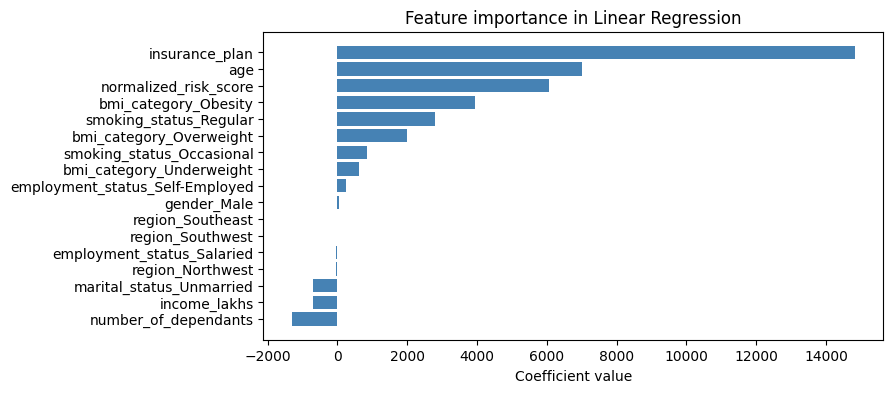

In [89]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient",ascending=True)

py.figure(figsize=(8,4))
py.barh(coef_df.index,coef_df["Coefficient"],color="steelblue")
py.title("Feature importance in Linear Regression")
py.xlabel("Coefficient value")
py.show()


In [90]:
model_ridge = Ridge()
model_ridge.fit(X_train,Y_train)
test_score = model_ridge.score(X_test,Y_test)
train_score = model_ridge.score(X_train,Y_train)
train_score,test_score

(0.9534162332209687, 0.9538456995663842)

In [91]:
model_ridge = Lasso()
model_ridge.fit(X_train,Y_train)
test_score = model_ridge.score(X_test,Y_test)
train_score = model_ridge.score(X_train,Y_train)
train_score,test_score

(0.9534109910848642, 0.9538410443658304)

In [92]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,Y_train)
test_score = model_xgb.score(X_test,Y_test)
train_score = model_xgb.score(X_train,Y_train)
train_score,test_score

(0.9986370801925659, 0.9979538321495056)

In [93]:
model_xgb = XGBRegressor()

param_grid = {
    "n_estimators":[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
}

random_search = RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42)
random_search.fit(X_train,Y_train)
random_search.best_score_

np.float64(0.9970577955245972)

In [94]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [95]:
best_model = random_search.best_estimator_

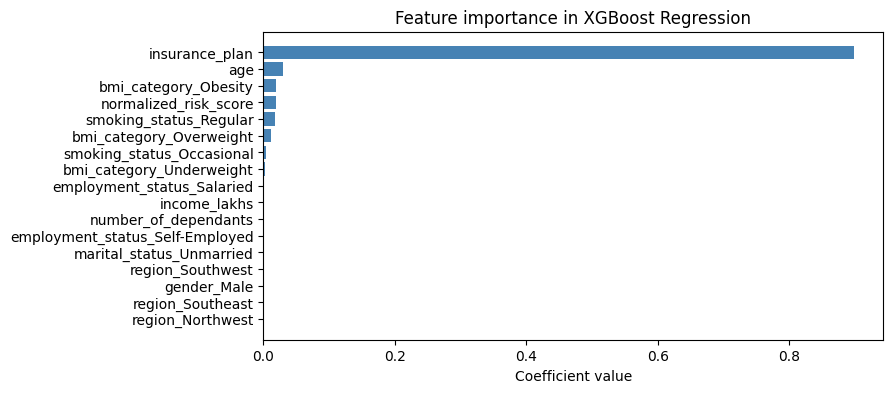

In [96]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient",ascending=True)

py.figure(figsize=(8,4))
py.barh(coef_df.index,coef_df["Coefficient"],color="steelblue")
py.title("Feature importance in XGBoost Regression")
py.xlabel("Coefficient value")
py.show()


### Error Analysis

In [99]:
y_pred = best_model.predict(X_test)

residuals = y_pred-Y_test
residual_pct = residuals*100/Y_test


results_df = pd.DataFrame({
    'actual':Y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residual_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


<Axes: xlabel='diff_pct', ylabel='Count'>

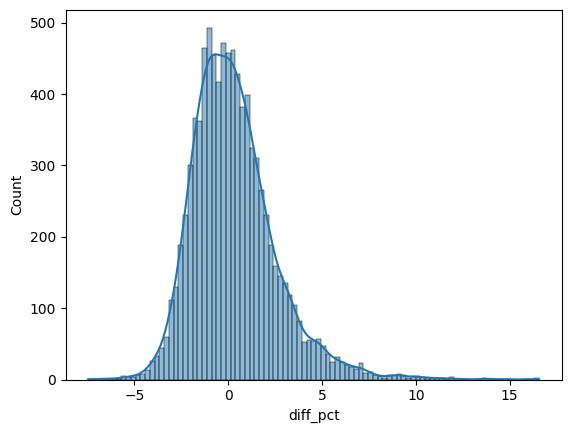

In [102]:
sns.histplot(results_df["diff_pct"],kde=True)

In [103]:
extreme_error_threshold = 10
extreme_result_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]

In [104]:
extreme_result_df.shape

(29, 4)

In [105]:
extreme_error_pct = extreme_result_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.32413099362914943

In [106]:
extreme_result_df.index

Index([14286, 27518,  9285,  7547, 21910, 12189, 21141, 16263,  8216, 13973,
        9150, 24145, 18522,  6163, 18681, 19145, 21455, 22666,  7508, 10741,
        6517, 18834, 13744, 24119,  2695, 25658, 11019, 14037,  7654],
      dtype='int64')

In [107]:
extreme_errors_df = X_test.loc[extreme_result_df.index]
extreme_errors_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14286,0.021739,0.6,0.050505,0.0,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
27518,0.304348,0.6,0.080808,0.0,0.357143,1,1,0,0,0,0,0,0,0,0,0,1
9285,0.326087,0.6,0.010101,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
7547,0.347826,0.2,0.080808,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.000000,1,0,0,1,0,0,0,0,0,0,1,0
21141,0.239130,0.6,0.000000,0.0,0.857143,0,0,0,1,0,0,0,0,0,0,0,1
16263,0.673913,0.6,0.383838,0.0,0.000000,1,1,0,0,0,0,0,0,0,0,0,0
8216,0.152174,0.4,0.010101,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,1,0
13973,0.152174,0.8,0.030303,0.0,0.857143,0,1,0,0,0,0,0,0,0,0,0,1


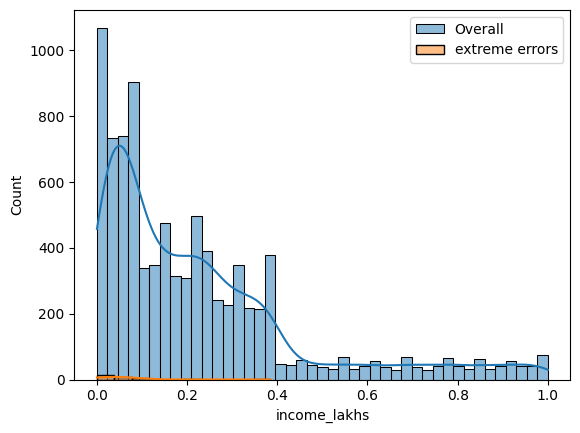

In [108]:
sns.histplot(X_test.income_lakhs,label="Overall",kde=True)
sns.histplot(extreme_errors_df.income_lakhs,label="extreme errors",kde=True)
py.legend()
py.show()

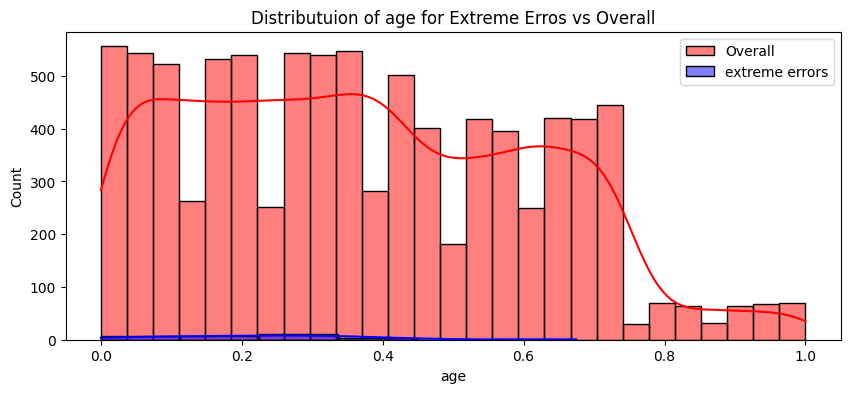

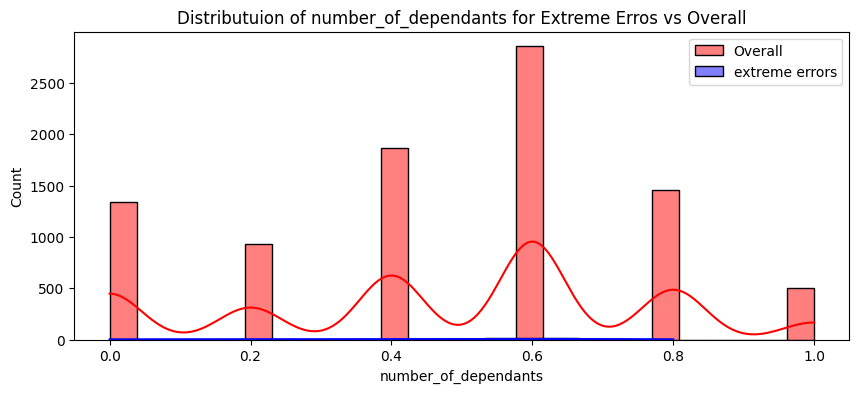

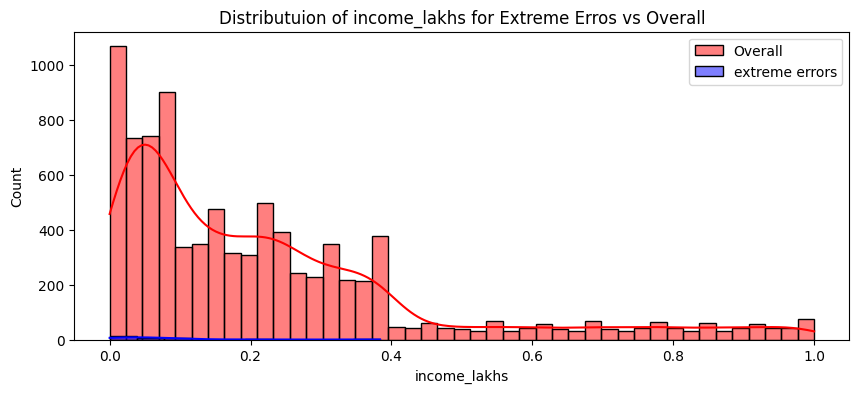

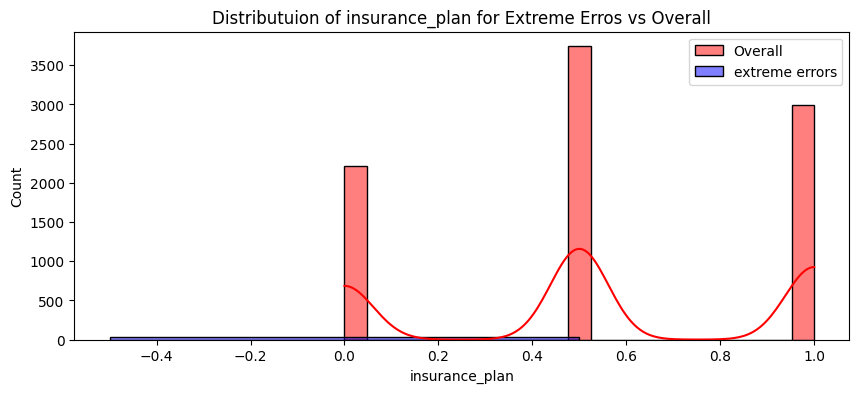

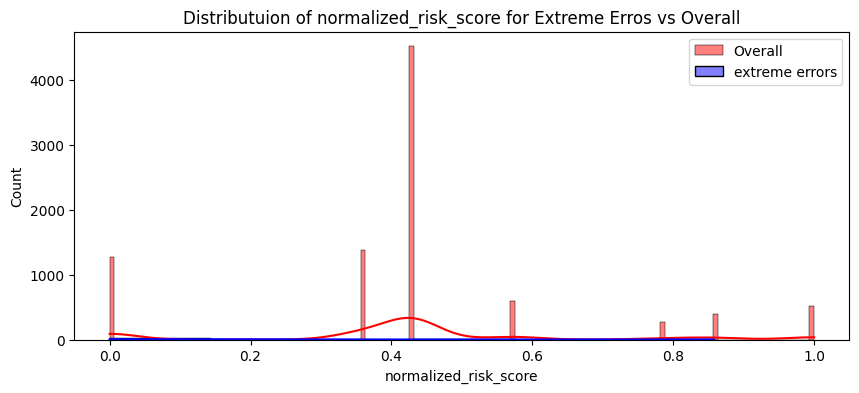

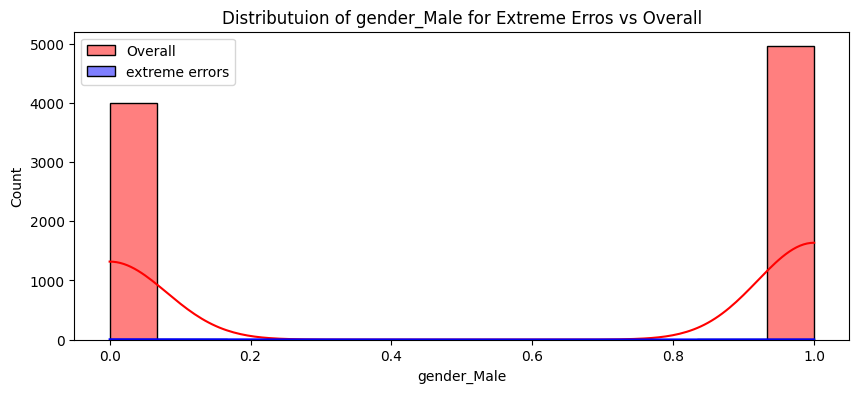

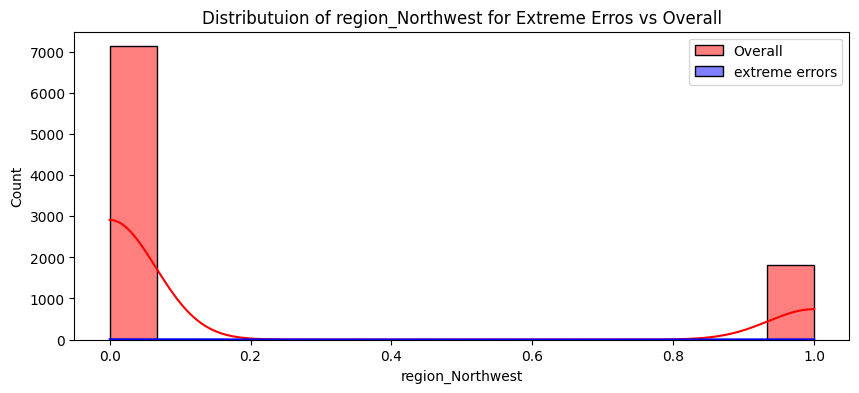

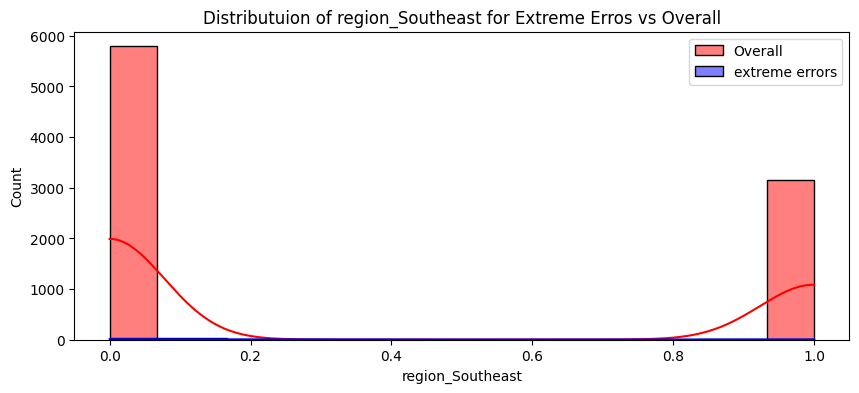

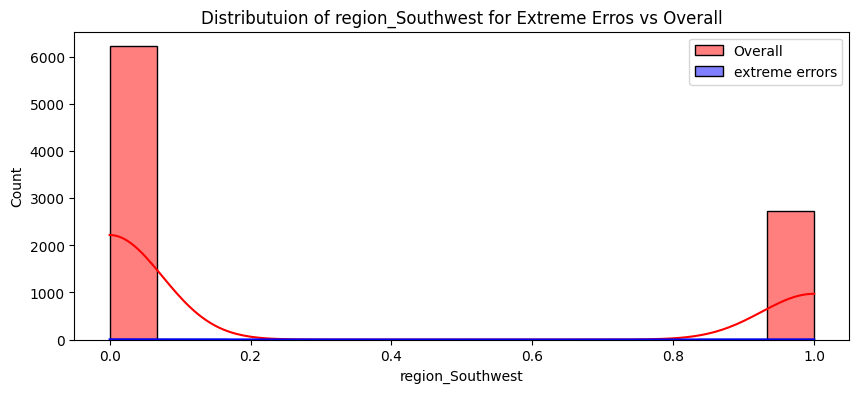

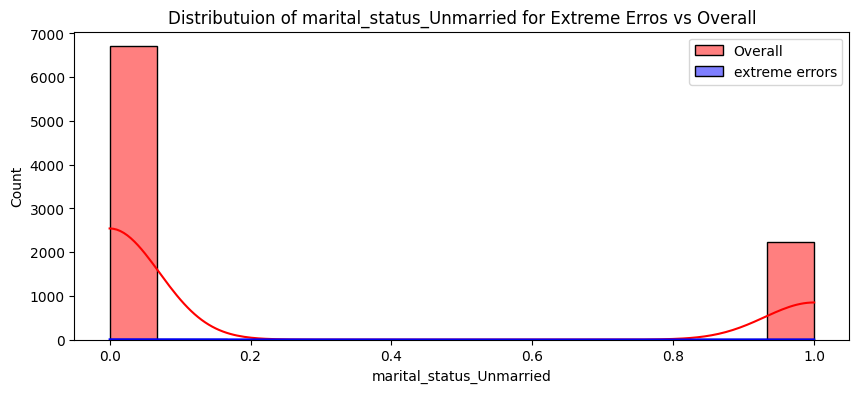

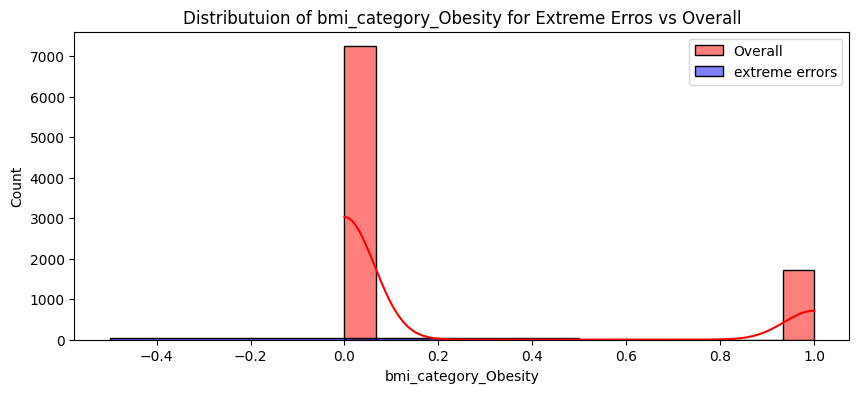

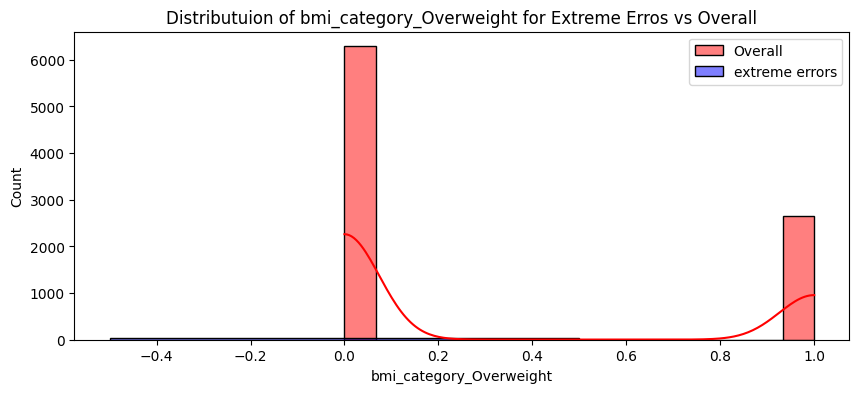

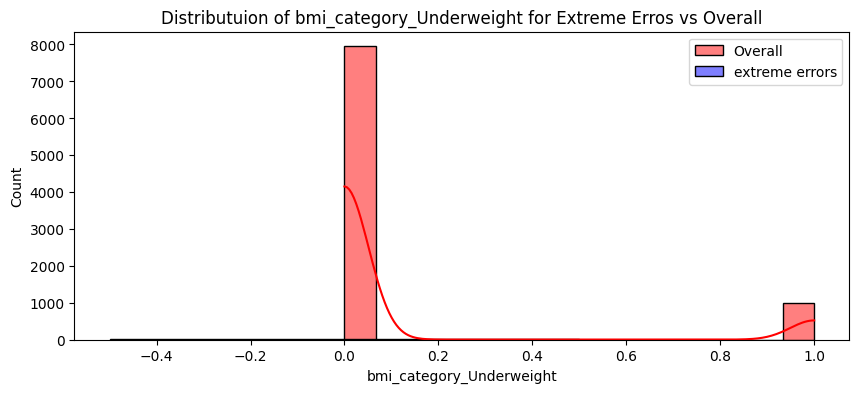

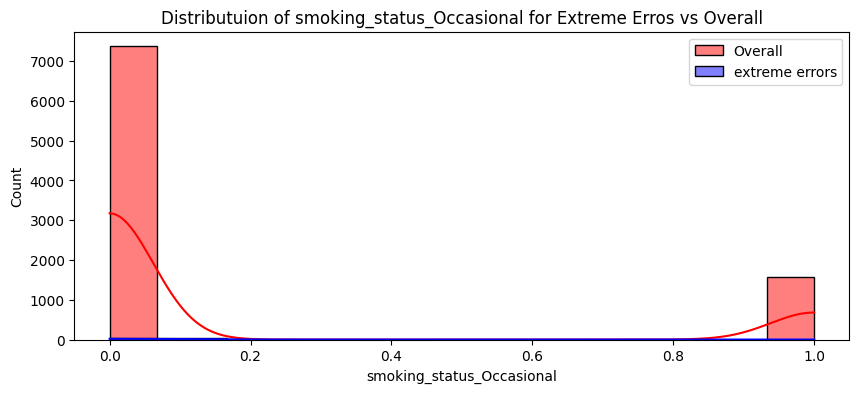

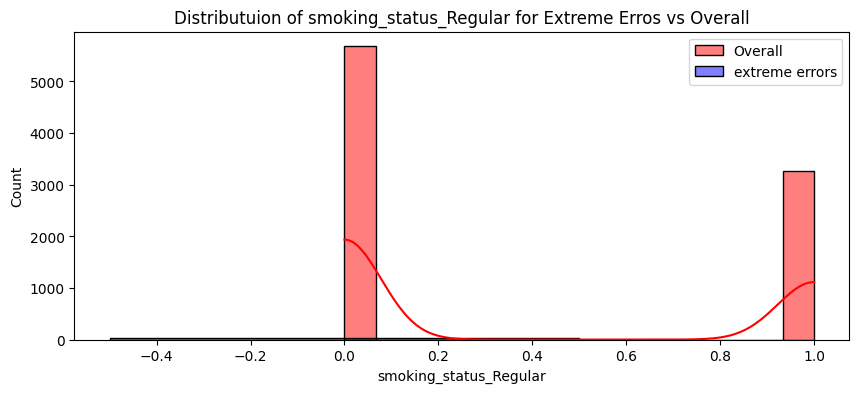

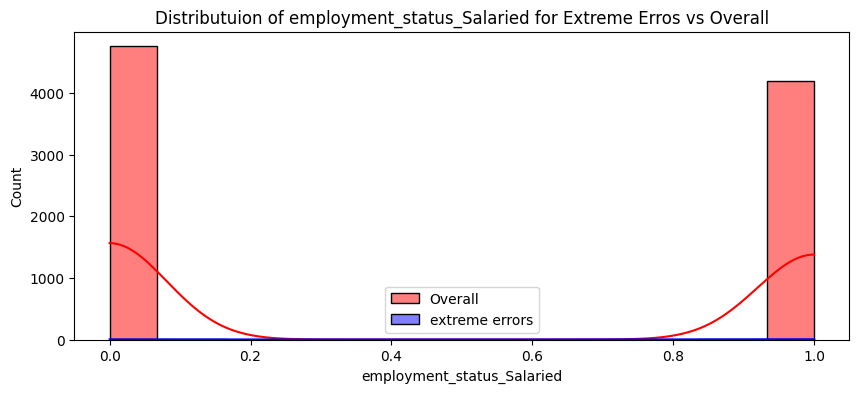

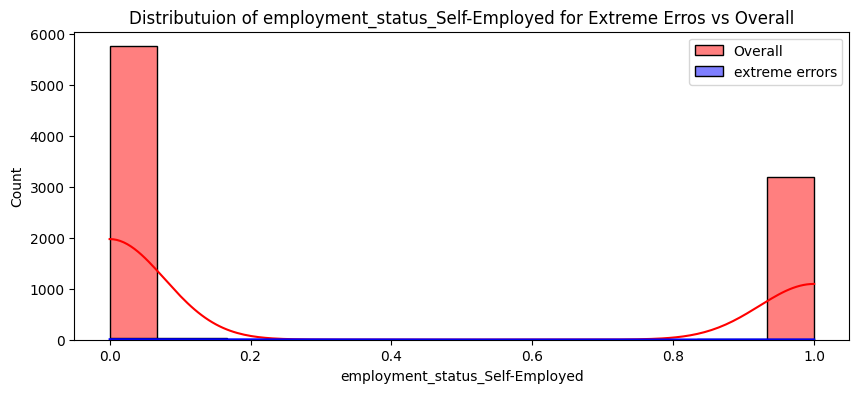

In [109]:
for feature in X_test.columns:
    py.figure(figsize=(10,4))
    sns.histplot(X_test[feature],label="Overall",color="red",kde=True)
    sns.histplot(extreme_errors_df[feature],color="blue",label="extreme errors",kde=True)
    py.legend()
    py.title(f"Distributuion of {feature} for Extreme Erros vs Overall")
    py.show()

<Axes: xlabel='age', ylabel='Count'>

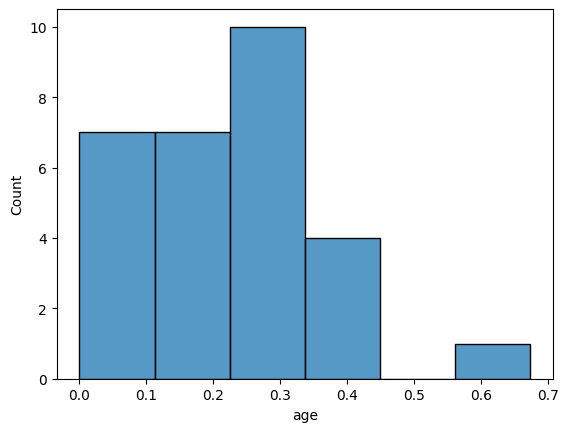

In [110]:
sns.histplot(extreme_errors_df.age)

In [111]:
extreme_errors_df["income_level"]=-1

<Axes: xlabel='age', ylabel='Count'>

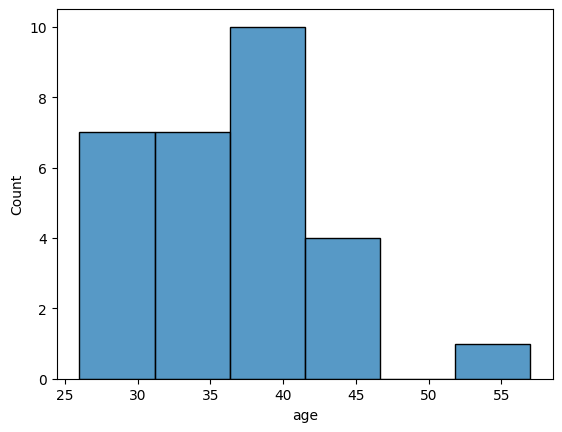

In [112]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = age_original = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed["age"])

In [113]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0
